# **HW5: Raining Cats and Dogs!**

Welcome to Python for Beginners! In this blog post, we will be diving into the world of image classification using deep learning!

***Our Goal:*** Build machine learning model in Keras that will be able to distinguish between cats and dogs!

We’ll walk through everything step by step — starting from loading and preprocessing the dataset to training a CNN (convolutional neural network) that classifies images as either a cat or a dog. Along the way, we’ll explore key concepts in computer vision, including convolutional layers, pooling, and data augmentation.

It’s going to be a crazy ride, so grab your umbrella - because without the right gear, it might just feel like it’s raining cats and dogs! ☔🐾

---


## **Setting Up Project**

### **Load Packages**
As always, we're going to start off with importing all the necessary libraries.

In [ ]:
import os
import keras
from keras import datasets, layers, models
import tensorflow as tf
from keras import utils
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

### **Obtain Data**
We got the following dataset from Kaggle that gives us labeled images of cats and dogs to work with.

To work with the dataset from TFDS (TensorFlow Datasets), we can load it and split it into 40% training, 10% validation, and 10% test sets:

In [ ]:
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # 40% training, 10% validation, and 10% test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    # Dataset is returned as (image, label) pairs
    as_supervised=True,
)

# Check number of samples in each split
print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.GKBCEA_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


### **Resize Images**
This next block contains code that helps us resize the images (of different shapes and sizes) to a fixed size of 150x150.

In [ ]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

### **Optimizing Data**

And finally, we will be optimizing our data for it to better work with our deep learning models, especially when we are working with large datasets.

**.batch(batch_size):** groups images in groups of "batch_size" (64 in this case) which in turn improves memory efficiency and parallel processing

**.prefetch(tf_data.AUTOTUNE):** allows the model to "fetch" the next batch of images, all while processing the current batch

**.cache():** if possible, stores dataset in memory

In [ ]:
from tensorflow import data as tf_data
batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

## **Working With Datasets**

In this next part, we will be writing a function to get used to working with datasets. In this function, we have to create a two-row visualization where the first row shows images of three random cats and the second row shows images of three random dogs.

First, we'll have to seperate the dataset into two: images and labels. From there, we will use the label to figure out if it is an image of a dog or a cat. Then, it is easy to seperate and plot the two.


In [ ]:
def show_images(train_ds):
  # Convert dataset into 2 lists
  image_list = []
  label_list = []

  # Iterate through small batch of images/labels
  for image, label in train_ds.take(1).as_numpy_iterator():
      image_list.append(image)
      label_list.append(label)

  # Convert lists into NumPy arrays
  image_array = np.array(image_list)
  label_array = np.array(label_list)

  # Split images into dogs and cats
  cats = image_array[label_array == 0]
  dogs = image_array[label_array == 1]

  # Pick 3 random cat and dog images
  num_samples = min(len(cats), len(dogs), 3)

  random_cats = random.sample(list(cats), num_samples)
  random_dogs = random.sample(list(dogs), num_samples)

  # Display
  fig, axes = plt.subplots(2, 3, figsize=(12, 6))

  # 3 cat images in the first row
  for i in range(3):
      axes[0, i].imshow(random_cats[i] / 255.0)
      axes[0, i].axis("off")
      axes[0, i].set_title("Cat")

  # 3 dog images in the second row
  for i in range(3):
      axes[1, i].imshow(random_dogs[i] / 255.0)
      axes[1, i].axis("off")
      axes[1, i].set_title("Dog")

  # Show
  plt.tight_layout()
  plt.show()

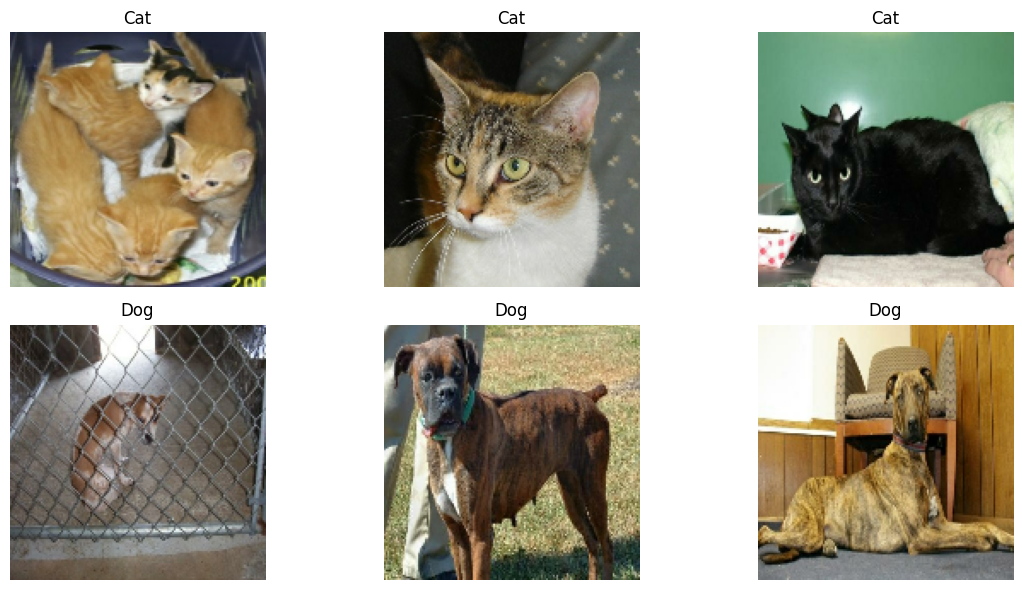

In [ ]:
show_images(train_ds)

Awww...how cute!

## **Label Distribution and Baseline Accuracy**

### **Label Distribution**
Before we train our model, we want to analyze our datasets label distribution, which is, how many dogs and cats are there? This line of code extracts the labels from the dataset.

In [ ]:
labels_iterator= train_ds.unbatch().map(lambda image, label: label).as_numpy_iterator()

With that information, we can print out the number of cats and dogs in our dataset to make sure there's not an imbalance between the two.

In [ ]:
labels = np.array(list(labels_iterator))

num_cats = np.sum(labels == 0)
num_dogs = np.sum(labels == 1)

print(f"Number of cats: {num_cats}")
print(f"Number of dogs: {num_dogs}")

Number of cats: 4637
Number of dogs: 4668


### **Baseline Accuracy**
A ***baseline model*** is the simplest model that makes predictions, without directly learning from the data. The baseline tends to predict the "majority class" so if there were 60% cats and 40% dogs, it would guess cats for 60% of the pictures.

Since our model is around a 50/50 split, we would predict the baseline model accuracy to be around 50%!

In [ ]:
total = num_cats + num_dogs
baseline = (max(num_cats, num_dogs) / total) * 100
print(f"Baseline accuracy: {baseline:.2f}%")

Baseline accuracy: 50.17%


We were right!

## **Building and Training a CNN Model**

Now, let's get to the *good* stuff. We will start off by building a simple Keras Sequential model to classify images of cats and dogs. We want to start off with **at least**:

*   **2 Conv2D layers:** detects small/complex (based on filter size) patterns, like edges and textures, in the image using 32 (64, 128, etc.) filters of size 3x3.
*   **2 MaxPooling2D layers:** reduces the image size by taking the most important features from a 2x2 region to make the model more efficient
*   **1 Flatten layer:** converts 2D image data into a 1D array to prepare it for the fully connected layers
*   **1 Dropout layer:** randomly turns off 50% (or however any) of neurons to prevent overfitting and improve generalization
*   **1 Dense layer:** outputs a probability between 0 and 1 which determines whether the image is a cat or a dog

We will play around with the parameters until we get at least **55% validation accuracy!**


#### **Creating the Model**

In [ ]:
model1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Compiling the Model**
The compile() function essentially configures how the model learns!
*   **optimizer='adam':** adjusts weights efficiently to minimize errors during training (adam = Adaptive Moment Estimation)
*   **loss="binary_crossentropy:"** measures how well the model distinguishes between the two classes (cats vs. dogs)
*   **metrics=['accuracy']:** tracks the percentage of correctly classified images





In [ ]:
model1.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

#### **Training the Model**

The fit() function uses the training data to train the model and validates it using the validation data!
*   **train_ds:** this is the dataset that is used for training the model, where the model learns patterns
*   **epochs=20:** the model will iterate through the training data 20 times to adjust weights and minimize errors
*   **validation_data=validation_ds:** evaluates the model's performance after each epoch using the validation dataset which helps track how well the model generalizes to new, unseen data




In [ ]:
history = model1.fit(train_ds,
                     epochs=20,
                     validation_data=validation_ds)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.5214 - loss: 103.9403 - val_accuracy: 0.5327 - val_loss: 0.6821
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5922 - loss: 0.6596 - val_accuracy: 0.5503 - val_loss: 0.7064
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6649 - loss: 0.5952 - val_accuracy: 0.5456 - val_loss: 0.7385
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7212 - loss: 0.5119 - val_accuracy: 0.5641 - val_loss: 0.9743
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7778 - loss: 0.4484 - val_accuracy: 0.5838 - val_loss: 0.8604
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8155 - loss: 0.3833 - val_accuracy: 0.5838 - val_loss: 1.0832
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8565 - loss: 0.3123 - val_accuracy: 0.5632 - val_loss: 1.5482
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8870 - loss: 0.2848 - val_a

### **Understanding Training vs. Validation Curves**
We plot training and validation accuracy data to help us see what is going on with the model. In order to analyze correctly, here is what to look out for:

*   **Training Accuracy Curve:** this line shows how well the model performs on the data it was trained on. It usually improves over time as the model learns.
*   **Validation Accuracy Curve:** this line shows how well the model generalizes to unseen data (validation set). Ideally, this should also increase, but it can sometimes behave differently.



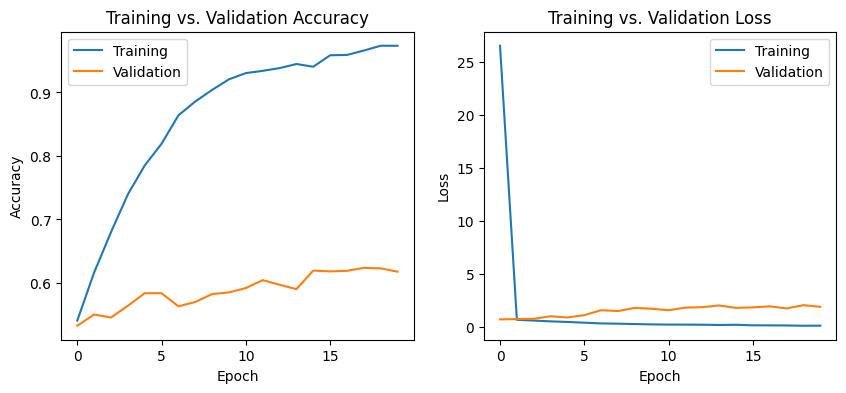

In [ ]:
# Create figure
plt.figure(figsize=(10,4))

# Plot Training vs. Validation Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label = "Training")
plt.plot(history.history["val_accuracy"], label = "Validation")
plt.gca().set(xlabel = "Epoch", ylabel = "Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()

# Plot Training vs. Validation Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label = "Training")
plt.plot(history.history["val_loss"], label = "Validation")
plt.gca().set(xlabel = "Epoch", ylabel = "Loss")
plt.title("Training vs. Validation Loss")
plt.legend()

# Show
plt.show()

#### **Training vs. Validation Plots**
In our **"Training vs. Validation Accuracy"** graph, we can observe that the training accuracy increases and starts to plateau slowly. Our validation accuracy is significantly lower and remains more or less a flat line throughout, with a slight increase.

**What This Means:**
*   ***Training accuracy higher than validation:*** indicates that the model is learning well on the training data, but is struggling to generalize to the validation set (a sign of overfitting if the gap widens over time).
*   ***Validation accuracy higher than training:*** this can happen in early training, especially if the model is underfitting (not complex enough). It usually indicates the model hasn’t fully learned the training data yet.

#### **Training vs. Validation Loss**
In our **"Training vs. Validation Loss"** graph, we can observe that the training loss quickly drops from high to low, forming an L-shape, while the validation loss remains flatter throughout, with a slight increase.

**What This Means:**
*   ***Validation loss higher than training:*** his can happen in the early stages of training, especially if the model is underfitting (not complex enough or not learning enough from the data). It typically indicates that the model hasn't yet learned to capture the patterns in the training data effectively. Over time, as the model improves, the validation loss should ideally decrease, but if it stays high while training loss continues to decrease, it could indicate a generalization issue.
*   ***Training loss higher than validation:*** this indicates that the model isn't learning as efficiently from the training data as it should, and it may need more training time or a more complex model to improve performance.


### **Test Accuracy**
After training the model, it's important to see how well the model performs on unseen test data. This is done using the evaluate() method:

In [ ]:
test_loss, test_acc = model1.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2%}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.5952 - loss: 1.8894
Test Accuracy: 60.40%


In [ ]:
val_loss, val_acc = model1.evaluate(validation_ds)
print(f"Validation Accuracy: {val_acc:.2%}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6166 - loss: 1.9826
Validation Accuracy: 61.78%


#### **Analyzing the Accuracy**


1.   **The validation accuracy of my model stabilized to 60.58% during training.**


2.   As calculated earlier, the baseline accuracy was coming out to be around 50%. Our model, with its 61.78% accuracy, is doing better than baseline by around 10%, which shows an improvement in generalization.
3.   Yes, since our training accuracy exceeds validation accuracy, we observe overfitting in our model.



## **Adding Data Augmentation**
To get our model to differentiate between images of cats and dogs better, we will be adding data augmentation layers to our model. What data augmentation layers do is create transformed versions of the input images during training to help the model generalize better. These layers apply random modifications to the images such as flipping and rotating to increase data diversity without needing more labeled images.

#### **Random Flip Layer**
We will start of with creating a keras.layers.RandomFlip() layer. We can have this flip the image horizontally, vertically, or both, by specifying with mode. For this example, we will set mode = "horizontal" which will flip the images along the horizontal axis.


In [ ]:
flipped = layers.RandomFlip(mode = "horizontal")

In [ ]:
sample_image, _ = next(iter(train_ds.unbatch().take(1)))

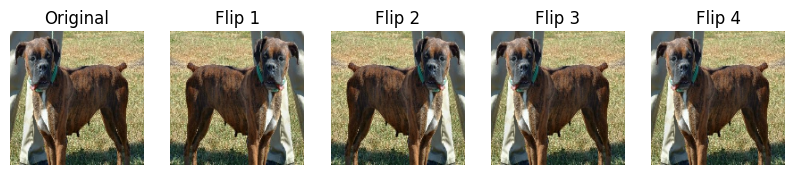

In [ ]:
# Plot original + 4 flipped versions
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 5, 1)
plt.imshow(sample_image.numpy().astype("uint8"))
plt.title("Original")
plt.axis("off")

# Apply RandomFlip multiple times
for i in range(4):
    flipped_image = flipped(sample_image)
    plt.subplot(1, 5, i + 2)
    plt.imshow(np.array(flipped_image).astype("uint8"))
    plt.title(f"Flip {i+1}")
    plt.axis("off")

plt.show()

Transformations like flipping, rotating, and cropping are applied randomly to each image during training. This means that every time the model runs, the augmented versions of images may look different.

#### **Random Rotation Layer**
Next, we will make a keras.layers.RandomRotation() layer which will randomly rotate the image during training and helps the model be better when there are variations in object orientation.

In [ ]:
randomroto = layers.RandomRotation(0.2)

In [ ]:
sample_image, _ = next(iter(train_ds.unbatch().take(1)))  # Take a single image

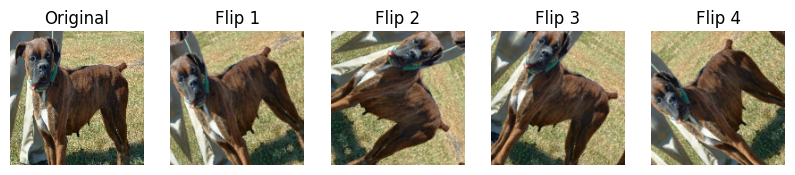

In [ ]:
# Plot original + 4 flipped versions
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 5, 1)
plt.imshow(sample_image.numpy().astype("uint8"))
plt.title("Original")
plt.axis("off")

# Apply RandomFlip multiple times
for i in range(4):
    flipped_image = randomroto(sample_image)  # Apply RandomFlip
    plt.subplot(1, 5, i + 2)
    plt.imshow(np.array(flipped_image).astype("uint8"))
    plt.title(f"Flip {i+1}")
    plt.axis("off")

plt.show()

### **Model With Data Augmentation Layers**

Now, we’ll integrate the data augmentation layers into our model we created above to see if these new layers improve the model's ability to distinguish between cats and dogs. By adding random flipping and rotation, we expose the model to more variations in image orientation which in turn helps it learn more generalizable features rather than memorizing specific image patterns to prevent overfitting and improve validation accuracy.

#### **Creating the Model**

In [ ]:
model2 = keras.Sequential([
    # Data augmentation layers
    flipped,
    randomroto,

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

#### **Compiling the Model**

In [ ]:
# Compile the model
model2.compile(optimizer="adam",
               loss="binary_crossentropy",
               metrics=["accuracy"]
              )

#### **Training the Model**

In [ ]:
# Train the model for 20 epochs
history2 = model2.fit(train_ds,
                      epochs=20,
                      validation_data=validation_ds
                     )

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.5437 - loss: 27.9833 - val_accuracy: 0.6131 - val_loss: 0.6547
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5951 - loss: 0.6623 - val_accuracy: 0.6290 - val_loss: 0.6451
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6008 - loss: 0.6656 - val_accuracy: 0.6341 - val_loss: 0.6394
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6237 - loss: 0.6548 - val_accuracy: 0.6599 - val_loss: 0.6256
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6290 - loss: 0.6462 - val_accuracy: 0.6647 - val_loss: 0.6119
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6346 - loss: 0.6378 - val_accuracy: 0.6660 - val_loss: 0.6300
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6141 - loss: 0.6599 - val_accuracy: 0.6582 - val_loss: 0.6340
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.6373 - loss: 0.6422 - val_a

### **Training vs. Validation Plots**
Same principles as above apply here to analyze our plots.

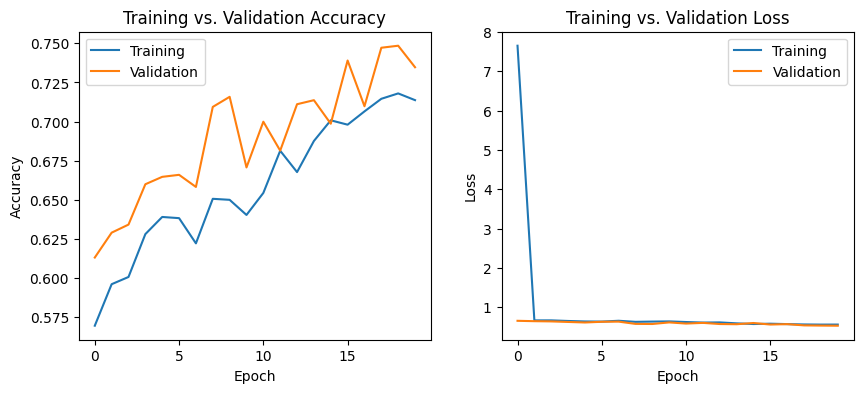

In [ ]:
# Create figure
plt.figure(figsize=(10,4))

# Plot Training vs. Validation Accuracy
plt.subplot(1,2,1)
plt.plot(history2.history["accuracy"], label = "Training")
plt.plot(history2.history["val_accuracy"], label = "Validation")
plt.gca().set(xlabel = "Epoch", ylabel = "Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()

# Plot Training vs. Validation Loss
plt.subplot(1,2,2)
plt.plot(history2.history["loss"], label = "Training")
plt.plot(history2.history["val_loss"], label = "Validation")
plt.gca().set(xlabel = "Epoch", ylabel = "Loss")
plt.title("Training vs. Validation Loss")
plt.legend()

# Show
plt.show()

**Training vs. Validation Accuracy**
*   Both training and validation accuracy show an upward trend, which indicates that the model is learning over time.
*   The validation accuracy closely follows the training accuracy, which indicates minimal overfitting and a good generalization to unseen data.
*   Accuracy reaches around 62%, which is an improvement from the baseline.

**Training vs. Validation Loss**
*   The training loss starts very high but drops instantly, forming an "L" shape.
*   The validation loss remains flat throughout and much lower than the training loss, which is unusual.

**Overall**
*   The model improves in accuracy, showing successful learning.
*   There is no extreme overfitting, as validation and training accuracy remain close.


In [ ]:
test_loss, test_acc = model2.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2%}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7194 - loss: 0.5441
Test Accuracy: 73.04%


In [ ]:
val_loss, val_acc = model2.evaluate(validation_ds)
print(f"Validation Accuracy: {val_acc:.2%}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7368 - loss: 0.5196
Validation Accuracy: 73.47%


### **Analyzing the Accuracy**


1.   **The validation accuracy of this model is 73.47%.**
2.   This validation accuracy of 73.47% shows great improvement from the previous model accuracy of 61.78%. There is an increase of around 12%.
3.   There isn't any severe overfitting, as validation accuracy does not lag far behind training accuracy.

## **Data Preprocessing**
To make our model better and more efficient, it is good to apply simple transformations to the input data before training. This is called preprocessing.

In this case, our image pixels have RGB values ranging from 0 to 255, but many models train more efficiently when these values are normalized between 0 and 1 (or -1 and 1).

The following code block shows us how to normalize our values:

In [ ]:
i = keras.Input(shape=(150, 150, 3))
# The pixel values have the range of (0, 255), but many models will work better if rescaled to (-1, 1.)
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(i)
preprocessor = keras.Model(inputs = i, outputs = x)

#### **Creating the Model**

In [ ]:
model3 = keras.Sequential([
    # Preprocessor layer
    preprocessor,

    flipped,
    randomroto,

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

#### **Compiling the Model**

In [ ]:
# Compile the model
model3.compile(optimizer="adam",
               loss="binary_crossentropy",
               metrics=["accuracy"]
              )

#### **Training the Model**

In [ ]:
# Train the model for 20 epochs
history3 = model3.fit(train_ds,
                      epochs=20,
                      validation_data=validation_ds
                     )

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.5534 - loss: 0.9582 - val_accuracy: 0.6496 - val_loss: 0.6330
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6345 - loss: 0.6363 - val_accuracy: 0.7167 - val_loss: 0.5682
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.6792 - loss: 0.5959 - val_accuracy: 0.7240 - val_loss: 0.5391
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6998 - loss: 0.5779 - val_accuracy: 0.7339 - val_loss: 0.5277
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.7166 - loss: 0.5581 - val_accuracy: 0.7244 - val_loss: 0.5331
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7241 - loss: 0.5464 - val_accuracy: 0.7567 - val_loss: 0.5009
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7353 - loss: 0.5260 - val_accuracy: 0.7554 - val_loss: 0.4939
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7376 - loss: 0.5330 - val_acc

### **Training vs. Validation Plots**

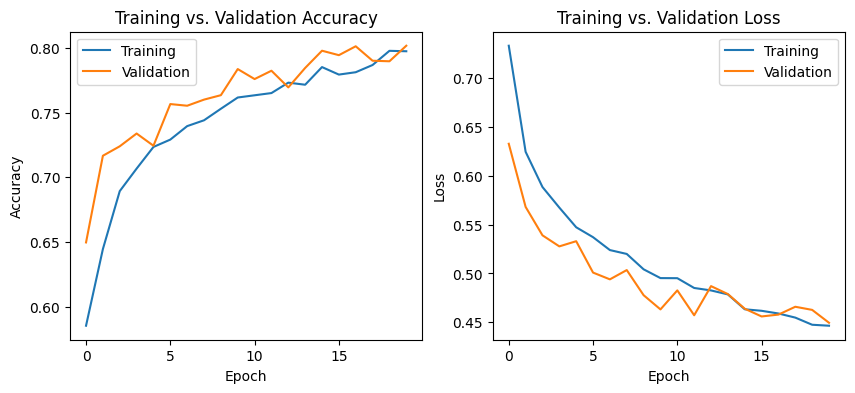

In [ ]:
# Create figure
plt.figure(figsize=(10,4))

# Plot Training vs. Validation Accuracy
plt.subplot(1,2,1)
plt.plot(history3.history["accuracy"], label = "Training")
plt.plot(history3.history["val_accuracy"], label = "Validation")
plt.gca().set(xlabel = "Epoch", ylabel = "Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()

# Plot Training vs. Validation Loss
plt.subplot(1,2,2)
plt.plot(history3.history["loss"], label = "Training")
plt.plot(history3.history["val_loss"], label = "Validation")
plt.gca().set(xlabel = "Epoch", ylabel = "Loss")
plt.title("Training vs. Validation Loss")
plt.legend()

# Show
plt.show()

**Training vs. Validation Accuracy**


*   The validation accuracy and training accuracy both show a steady increase close together, eventually stabilizing close to around 80%.
*   The validation accuracy remains slightly higher than the training accuracy, which means there is good generalization without much overfitting.
*   The model performs well on unseen data, which means it is learning effectively.

**Training vs. Validation Loss**

*   Both training and validation loss decrease over time, which is a sign of successful learning.
*   The curves are close, meaning the model is not overfitting and maintains a good balance between training and validation performance.

In [ ]:
test_loss, test_acc = model3.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2%}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7783 - loss: 0.4538
Test Accuracy: 79.36%


In [ ]:
# Evaluate on validation dataset
val_loss, val_acc = model3.evaluate(validation_ds)
print(f"Validation Accuracy: {val_acc:.2%}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7957 - loss: 0.4574
Validation Accuracy: 80.18%


#### **Analyzing the Accuracy**
1.   **The validation accuracy of our model with an additional layer of preprocessing reaches 80.18%.**
2.   The validation accuracy of this model is a significant increase from model 1 from 61.78% accuracy to 80.18% accuracy, an increase of around 19%.
3.   There is no significant overfitting observed in this model, as the validation accuracy closely follows the training accuracy, indicating good generalization to unseen data.

## **Transfer Learning**
What we have been doing thus far is training models from scratch to distinguish between cats and dogs. But what if we could build on existing knowledge instead of starting fresh? That’s where ***transfer learning*** comes in.

Rather than training a model from the ground up, we can use a pretrained base model, which is a model that has already learned useful features from a massive dataset. For image classification tasks, models like **MobileNetV3Large** have been trained on millions of images and can recognize patterns like edges, textures, and shapes. By incorporating such a model into our workflow, we can take advantage of these learned features and fine-tune them for our specific task.

The following code downloads MobileNetV3Large and configures it as a layer in our model:

In [ ]:
IMG_SHAPE = (150, 150, 3)
base_model = keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

i = keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = keras.Model(inputs = i, outputs = x)

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### **Creating the Model**

In [ ]:
model4 = keras.Sequential([
    flipped,
    randomroto,
    base_model_layer,
    layers.GlobalMaxPooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

#### **Compiling the Model**

In [ ]:
model4.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy']
               )

#### **Training the Model**

In [ ]:
history4 = model4.fit(train_ds,
                      epochs=20,
                      validation_data=validation_ds)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.6939 - loss: 3.4024 - val_accuracy: 0.9540 - val_loss: 0.2699
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.8867 - loss: 0.8977 - val_accuracy: 0.9678 - val_loss: 0.1746
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.9043 - loss: 0.7033 - val_accuracy: 0.9712 - val_loss: 0.1501
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9139 - loss: 0.5158 - val_accuracy: 0.9712 - val_loss: 0.1621
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9190 - loss: 0.4622 - val_accuracy: 0.9742 - val_loss: 0.1150
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9119 - loss: 0.4014 - val_accuracy: 0.9690 - val_loss: 0.1351
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9214 - loss: 0.3532 - val_accuracy: 0.9721 - val_loss: 0.1068
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9191 - loss: 0.3440 - val_a

### **Training vs. Validation Plots**

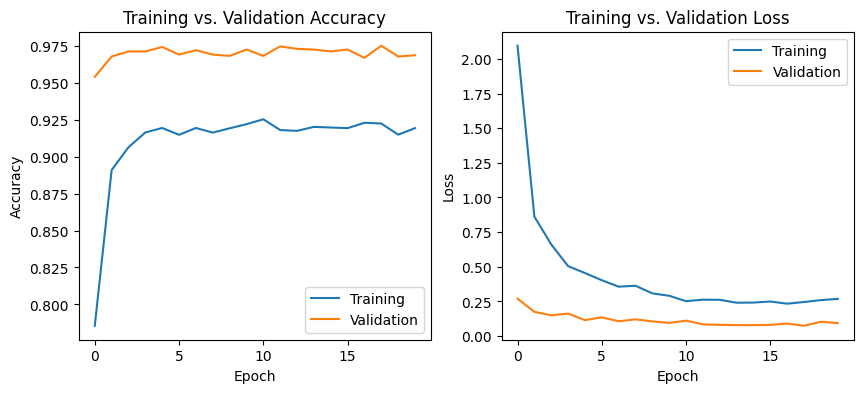

In [ ]:
# Create figure
plt.figure(figsize=(10,4))

# Plot Training vs. Validation Accuracy
plt.subplot(1,2,1)
plt.plot(history4.history["accuracy"], label = "Training")
plt.plot(history4.history["val_accuracy"], label = "Validation")
plt.gca().set(xlabel = "Epoch", ylabel = "Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()

# Plot Training vs. Validation Loss
plt.subplot(1,2,2)
plt.plot(history4.history["loss"], label = "Training")
plt.plot(history4.history["val_loss"], label = "Validation")
plt.gca().set(xlabel = "Epoch", ylabel = "Loss")
plt.title("Training vs. Validation Loss")
plt.legend()

# Show
plt.show()

**Training vs. Validation Accuracy**
*   The training accuracy steeply increases and plateaus around 92.5%.
*   The validation accuracy remains consistently higher than the training accuracy, fluctuating around 96%.
*   This suggests that the model is well-trained and generalizes well on the validation set.

**Training vs. Validation Loss**
*   The training loss decreases over epochs but still remains higher than the validation loss.
*   The validation loss is consistently lower than the training loss.
*   This unusual trend (validation performing better than training) could be due to strong regularization techniques (e.g., dropout, batch normalization) or differences in dataset distributions.










In [ ]:
test_loss, test_acc = model4.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2%}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9652 - loss: 0.1055
Test Accuracy: 96.35%


In [ ]:
val_loss, val_acc = model4.evaluate(validation_ds)
print(f"Validation Accuracy: {val_acc:.2%}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9636 - loss: 0.1169
Validation Accuracy: 96.86%


### **Analyzing the Accuracy**
In bold font, describe the validation accuracy of your model during training.
Comment on this validation accuracy in comparison to the accuracy you were able to obtain with model1.
Comment again on overfitting. Do you observe overfitting in model4?

1.   **The validation accuracy of this model is 96.86%.**
2.   The validation accuracy of this model at 96.86% is much higher than our first model that had a validation accuracy of 61.78%. This is an increase of around 35%.
3.   Overfitting occurs when the model performs significantly better on the training data than on the validation data, meaning that it has memorized the training set rather than generalizing well. In this model, it does not show signs of overfitting since the validation accuracy remains consistently high and does not drop after a certain number of epochs, suggesting strong generalization. Since the test accuracy (96.35%) closely matches the validation accuracy, it confirms that the model is performing well on unseen data and is not overfitting.